In [1]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

In [ ]:
df = pd.read_csv('../data/GosaiMPRA/GosaiMPRA_my_processed_data.csv')
df

In [ ]:
df = df[df['seq'].str.len() == 200].reset_index(drop=True)
df

In [2]:
MPRA_df = pd.read_csv('../data/GosaiMPRA/GosaiMPRA_my_processed_data_len200.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.554,0.416,0.442,NaN,-0.288
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-0.704,0.668,0.539,NaN,0.159
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-0.659,1.152,0.205,NaN,1.051
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.391,1.270,0.752,NaN,1.100
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.007,-0.211,0.499,NaN,0.258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760696,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,1.381,1.846,1.702,NaN,NaN
760697,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.306,-0.107,-0.080,NaN,NaN
760698,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,0.363,0.261,0.060,NaN,NaN
760699,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,0.395,0.378,-0.030,NaN,NaN


In [3]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)
data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref')
data_split_dict['alt'] = ~data_split_dict['ref']

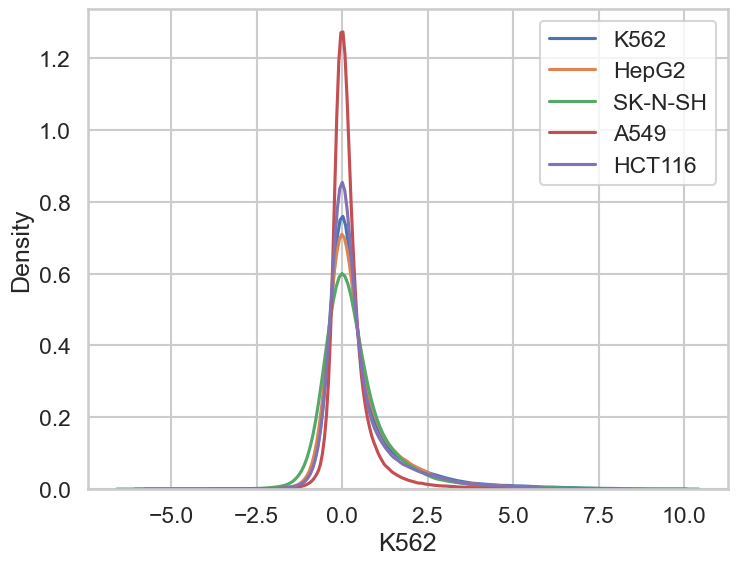

In [4]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'A549', 'HCT116']

plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
for i, cell_type in enumerate(cell_types):
    x = MPRA_df[cell_type]
    sns.kdeplot(x, label=cell_type)
# plt.xlabel(f'{assay}')

plt.legend()
plt.savefig(f'figures/kde_GosaiMPRA_exp_dist.png', dpi=400)
plt.show()

In [5]:
# normalize between different cell types

for i, cell_type in enumerate(cell_types):
    x = MPRA_df[cell_type]
    condition = data_split_dict['train']
    x_mean = np.mean(x[condition])
    x_std = np.std(x[condition])
    x = (x - x_mean) / x_std
    MPRA_df[cell_type] = x


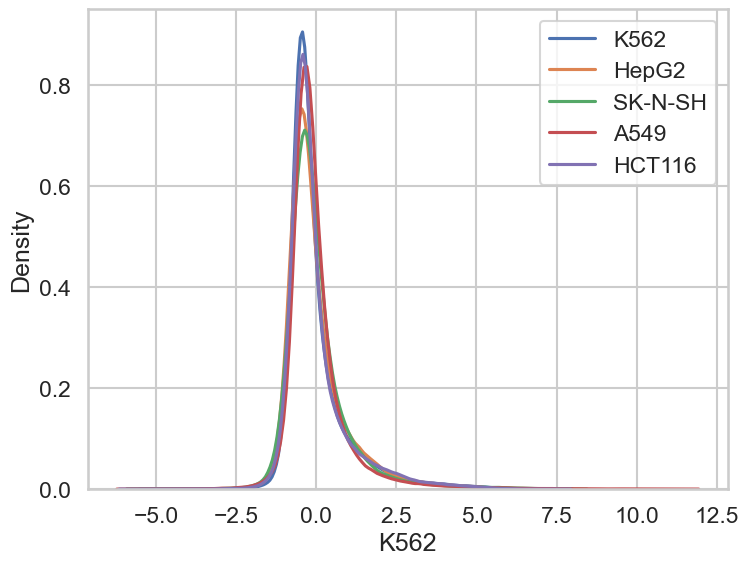

In [6]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'A549', 'HCT116']

plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
for i, cell_type in enumerate(cell_types):
    x = MPRA_df[cell_type]
    sns.kdeplot(x, label=cell_type)
# plt.xlabel(f'{assay}')

plt.legend()
plt.savefig(f'figures/kde_GosaiMPRA_exp_dist_norm.png', dpi=400)
plt.show()

In [9]:
# 各细胞类型的真实活性的相关性
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'A549', 'HCT116']

corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types, dtype=float)
for cell_type in cell_types:
    for cell_type_2 in cell_types:
        x, y = MPRA_df[f'{cell_type}'], MPRA_df[f'{cell_type_2}']
        r, p = pearson(x, y)
        corr_matrix.loc[cell_type, cell_type_2] = r

corr_matrix.loc['A549', 'HCT116'] = np.nan
corr_matrix.loc['HCT116', 'A549'] = np.nan
print(corr_matrix)
print()

         K562  HepG2  SK-N-SH  A549  HCT116
K562    1.000  0.801    0.759 0.724   0.825
HepG2   0.801  1.000    0.836 0.730   0.879
SK-N-SH 0.759  0.836    1.000 0.777   0.833
A549    0.724  0.730    0.777 1.000     NaN
HCT116  0.825  0.879    0.833   NaN   1.000



In [8]:
MPRA_df.to_csv('../data/GosaiMPRA/GosaiMPRA_my_processed_data_len200_norm.csv', index=False)